# Process individual data files into one joined 

- Load all files as data frames
- join selected files into one 

In [28]:
#
## Spark essentials
#  
import pandas as pd
from pyspark.sql import SparkSession, Row
import pyspark.sql.functions as f

spark = SparkSession.builder\
    .master("local[*]")\
    .appName("main")\
    .config("spark.dynamicAllocation.enabled", "true")\
    .config("spark.shuffle.service.enabled", "true")\
    .getOrCreate()

input_dir = "spark_to_csv_1696257401.110592"

In [34]:
#
# Load all files into DFs
# 

def load_table(path, view_name):
    tbl = spark.read.csv(path, inferSchema="true", header="true", nullValue="NA")
    tbl.createOrReplaceTempView(view_name)
    return tbl

import os
all_tables = {}
for dir in os.listdir(input_dir):
    path = os.path.join(input_dir, dir)
    df = load_table(path, dir)
    all_tables[dir] = df 


In [60]:

df = all_tables["vaesto_31_12"]
for t in ["forecast_data", "asukkaiden_keskitulot_hr"]:
    df2 = all_tables[t]
    df = df.join(df2, "City")
pop_data = df
pop_data.show()


+-----------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------+------+------+------+------+------+------+------+------+------+------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+
|       City|2011_vaesto_31_12|2012_vaesto_31_12|2013_vaesto_31_12|2014_vaesto_31_12|2015_vaesto_31_12|2016_vaesto_31_12|2017_vaesto_31_12|2018_vaesto_31_12|2019_vaesto_31_12|2020_vaesto_31_12|2021_vaesto_31_12|2022_vaesto_31_12| Y2021| Y2022| Y2023| Y2024| Y2025| Y2026| Y2027| Y2028| Y2029| Y2030| Y2031|2010_asukkaiden_keskitulot_

## Notes

apartments_data_file is downloaded from https://github.com/maijams/propertyproject/blob/main/preprocessed_data/preprocessed_merged_apartments_population_2011-2022.csv

Changed one city nane: Espoo-Kauniainen => Espoo
```sed -i "" "s/Espoo-Kauniainen/Espoo/g" tmp.csv``` 

In [72]:

apartments_data_file = "data/Input/" + "preprocessed_merged_apartments_population_2011-2022.csv"
df = spark.read.option("delimiter", ",").csv(apartments_data_file, inferSchema="true", header="true")
pivot_rent = df.groupBy("City").pivot("Year").agg(f.mean("Rent per m2"))
for c in pivot_rent.columns:
    if c != "City":
        nc = "R" + str(c)
        pivot_rent = pivot_rent.withColumnRenamed(c, nc)

pivot_sell = df.groupBy("City").pivot("Year").agg(f.mean("Sales price per m2"))
for c in pivot_sell.columns:
    if c != "City":
        nc = "S" + str(c)
        pivot_sell = pivot_sell.withColumnRenamed(c, nc)

prop_data = pivot_rent.join(pivot_sell, "City")
prop_data.na.drop()
prop_data.show()

+------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|        City|             R2011|             R2012|             R2013|             R2014|             R2015|             R2016|             R2017|             R2018|             R2019|             R2020|             R2021|             R2022|             S2011|             S2012|             S2013|             S2014|             S2015|             S2016|             S2017|             S2018|             S2019|             S2020|             S2021|             S2022|
+------------+------------------+------------------+------

Coefficients: 
 [ 1.27168181e-04  3.52218995e-04 -6.93908960e-05 -7.84920585e-04
  1.64885436e-04  8.20778602e-04  1.27698514e-03 -1.77484252e-03
 -2.04073513e-03  1.50509465e-03 -7.62504129e-04 -5.42965013e-04
  1.12761903e-03  4.97368969e-04  1.61398220e-04 -5.84029090e-05
 -1.20327732e-04 -1.00974525e-04 -9.73358418e-05 -1.29239845e-04
 -6.21106486e-05  1.15169866e-04  3.89210693e-04  1.30620139e-04
 -4.69415656e-04  1.47184157e-04 -7.49767782e-04 -6.02922723e-04
 -7.41417592e-04  1.64144815e-03  1.93761296e-04  1.53601713e-04
  9.71086680e-04  5.64079052e-04 -1.31291425e-03  1.26207606e-05
  1.43023580e-05  1.13184363e-05  1.15682302e-05  1.91779084e-05
  2.03397003e-05  2.34247326e-05  2.43095052e-05  2.89408567e-05
  2.66285152e-05  2.52181372e-05  1.72880219e-03  1.86638723e-04
 -1.24391144e-04 -3.01184220e-05  4.52433463e-04  2.98669629e-04
  3.20001259e-04  1.02259514e-04  2.45801513e-04 -5.79066642e-04
  4.23034712e-04]
Mean squared error: 4.13
Coefficient of determination: 0

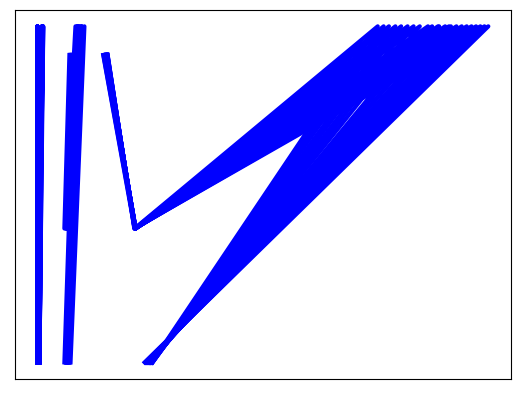

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

complete_data_set = pop_data.join(prop_data, "City")

all_cols = complete_data_set.columns

y_cols = ["R2022", "S2022", "City"]
x_cols = [c for c in all_cols if c not in y_cols]
X = complete_data_set[x_cols].toPandas()
y = complete_data_set[["R2022"]].toPandas()

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

model = LinearRegression().fit(X_train, y_train)

y_pred = model.predict(X_test)

# The coefficients
print("Coefficients: \n", model.coef_[0])
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Plot outputs
#plt.scatter(X_test, y_test, color="black")
plt.plot(X_test, y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()